In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import fit
import os
import numpy as np

In [ ]:
miles = fit.Dog('mile', 4)

In [ ]:
miles.description()

In [11]:
subject = 'sub-02'
deriv_dir = '/scratch/2021/nprf_ss/derivatives/'
scalar_dir = '/tank/klundert/projects/means/'
sub = fit.participant(subject, deriv_dir, scalar_dir)

In [ ]:
sub.__dict__

In [ ]:
sub.get_scalars()

In [ ]:
import nibabel as nb
import numpy as np
i = 0
for run in range(12):
    i = i+1
    run = run+1
    datvolm = nb.load(f'/tank/klundert/projects/means/sub-01/sub-01_ses-02_task-prf_run-{i}_mean.scalar.nii')
    mean = np.asanyarray(datvolm.dataobj)
    
    datvolm2 = nb.load(f'/tank/klundert/projects/means2/sub-01/sub-01_ses-02_task-prf_run-{i}_mean.scalar.nii')
    mean2 = np.asanyarray(datvolm2.dataobj)
    print((mean == mean2).mean())

In [ ]:
import nibabel as nb
import numpy as np
from nibabel import cifti2
def write_newcifti(filename, old_cifti, data_arr):
    """
    Saves a CIFTI file that has a new size of timepoints
    Parameters
    ----------
    filename : str
        name of output CIFTI file
    old_cifti : CIFTI file
        previous nibabel.cifti2.cifti2.Cifti2Image
    data_arr : array
        data to be stored as vector or matrix (shape: n_timepoints x n_voxels)
        or a scalar value for each voxel (shape: n_voxels)
    """

    # in case of data_arr where you have one value for each voxel (e.g. std for each voxel)
    if len(data_arr.shape) == 1: 
        matrix = cifti2.Cifti2Matrix()
        brain_model = old_cifti.header.get_axis(1)
        matrix.append(brain_model.to_mapping(0))
        newheader = cifti2.Cifti2Header(matrix)
        img = cifti2.Cifti2Image(data_arr, newheader)
        img.to_filename(filename)
        
    # in case of same or different 2 dimensional shape (e.g. removing first 3 TR of timeseries)
    else:
        start = old_cifti.header.get_axis(0).start
        step = old_cifti.header.get_axis(0).step
        brain_model = old_cifti.header.get_axis(1)  
        size = data_arr.shape[0]
        series = cifti2.SeriesAxis(start, step, size)
        brain_model = old_cifti.header.get_axis(1)
        newheader = cifti2.Cifti2Header.from_axes((series, brain_model))

        img = cifti2.Cifti2Image(data_arr, newheader)
        img.to_filename(filename)
    
    
    
datvol = nb.load('/scratch/2021/nprf_ss/derivatives/fmriprep/sub-01/ses-01/func/sub-01_ses-01_task-prf_run-10_space-fsLR_den-170k_bold.dtseries.nii')
dat = np.asanyarray(datvol.dataobj)
write_newcifti('/tank/klundert/check2.nii', datvol, dat[10:120])

In [ ]:
datvol = nb.load('/tank/klundert/check2.nii')
dat = np.asanyarray(datvol.dataobj)
dat.shape

In [12]:
sub.get_folds(remove_edge=True)

/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/projects/cfdn/prfpy-cfdn/fit.py:177: RuntimeWarning: Mean of empty slice
  self.data_train = np.nanmean(np.array(data[::2]), axis=0)
/tank/klundert/projects/cfdn/prfpy-cfdn/fit.py:178: RuntimeWarning: Mean of empty slice
  self.data_test = np.nanmean(np.array(data[1::2]), axis=0)


In [ ]:
import numpy as np
np.shape(sub.data)

In [21]:
import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

In [ ]:
# np.shape(sub.data[::2])

np.nanmean(np.array(sub.data[::2]), axis=0).shape

In [ ]:
import cortex as cx
f = cx.quickshow(cx.Vertex(get_cortex(np.nanmean(np.array(sub.data[::2]), axis=0)).mean(axis=1), subject='hcp_999999', cmap='inferno'), with_curvature=True);


In [22]:
from nilearn.surface import load_surf_data
import os

roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


ind = np.array(list(roi_index_dict.values()))[12:]
boolmask = atlas_data_both_hemis == roi_index_dict['LO1']

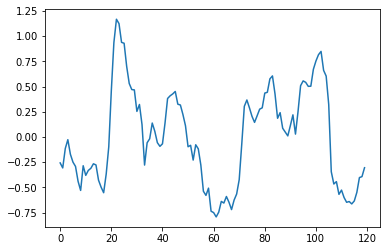

In [25]:
import matplotlib.pyplot as plt
# get_cortex(np.nanmean(np.array(sub.data[::2]), axis=0)).shape
# plt.plot()
plt.plot(get_cortex(s2_f)[boolmask].mean(axis=0))

In [24]:
s2_f = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full_zsc.npy")


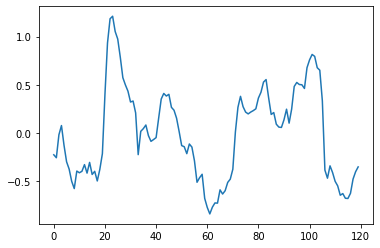

In [27]:
plt.plot(get_cortex(sub.data_test)[boolmask].mean(axis=0))